In [6]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18, vgg19, resnet50
from collections import Counter
import seaborn as sns

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
my_drive_path = 'models/'
train_path =  'train/'
test_path =  'test/'

We calculate the Mean and Standard Deviation of the training images here. They shall be used for normalizing the training and test datasets.

In [10]:
data_transform_without_normalization = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

image_dataset_train = datasets.ImageFolder(root=train_path, transform=data_transform_without_normalization)
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, batch_size=20, shuffle=False, num_workers=2)

We take random samples from the training dataset and normalize them using the Mean and Standard Deviation calculated above. We also normalize the random samples using the Mean and Standard Deviation of the ImageNet dataset. We visualize all of these below.

We divide the training dataset in the ratio 4:1 with 4 parts to be used for training and 1 part to be used for validation. The training, validation and test dataloaders are prepared next.

In [12]:
train_mean, train_std = [0.4268, 0.4069, 0.3794], [0.2792, 0.2735, 0.2714]
# ImageNet Norm: Mean = [0.485, 0.456, 0.406], Std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=train_mean, std=train_std)])

dataset_train = datasets.ImageFolder(root=train_path, transform=data_transforms)

train_idx, val_idx = train_test_split(list(range(len(dataset_train))), test_size=0.2, shuffle=True, random_state=0)

image_datasets = {'train': Subset(dataset_train, train_idx),
                  'validation': Subset(dataset_train, val_idx),
                  'test': datasets.ImageFolder(root=test_path, transform=data_transforms)}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=20, shuffle=True, num_workers=2),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=20, shuffle=False, num_workers=2),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=20, shuffle=False, num_workers=2)}

print('Labels = {}'.format(image_datasets['test'].class_to_idx))

print('Training dataset size = {}'.format(len(image_datasets['train'])))
# print('Training dataset distribution: {}'.format(dict(Counter(image_datasets['train']))))

print('Validation dataset size = {}'.format(len(image_datasets['validation'])))
# print('Validation dataset distribution: {}'.format(dict(Counter(image_datasets['validation']))))

print('Test dataset size = {}'.format(len(image_datasets['test'])))


Labels = {'norm': 0, 'weap': 1}
Training dataset size = 17132
Validation dataset size = 4283
Test dataset size = 4053


The below method generates the model used in this project. The Resnet50 with pretrained parameters is used as the baseline model. We add our own fully-connected layers with a dropout of 0.5.

In [13]:
def create_model():
  model = resnet50(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

    model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, 2))

    model = model.to(device)
    return model

This is the method to save the model after every epoch during training. We also save other metrics like the training loss, training accuracy, validation loss and validation accuracy observed for a particular epoch in the checkpoint so that they can be later used for generating visualizations.

This is the method which trains the model on the training data and then validates it on the validation dataset for the specified number of epochs. It invokes the save_model() method above to save the model checkpoint after every epoch.

In [ ]:
test_model = create_model()
# Checkpoint filename to load for testing
test_checkpoint_file = 'training_checkpoint_epoch_10.pth'

if device == 'cpu':
    test_checkpoint = torch.load(my_drive_path + test_checkpoint_file, map_location=torch.device('cpu'))
else:
    test_checkpoint = torch.load(my_drive_path + test_checkpoint_file)
test_model.load_state_dict(test_checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
import saliency.core as saliency
import PIL.Image

/home/mario/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None, file=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)
    if file is not None :
        plt.save()

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap='inferno')
    plt.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((224, 224))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [55]:
eval_mode = test_model.eval()

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = test_model.layer4[2].conv3
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().numpy()
conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)


In [56]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs


In [57]:
test_model_cpu = test_model.to('cpu')
model = test_model_cpu

Prediction class: 0


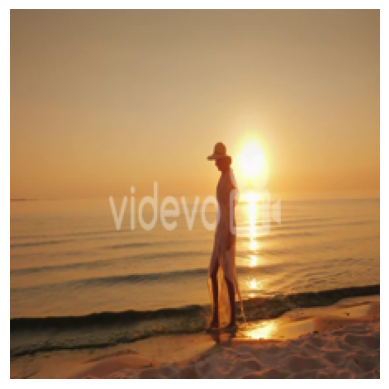

In [58]:
# Load the image
im_orig = LoadImage('test/norm/A0226619Y_04092022_NORMAL_1233_100.png')
im_tensor = PreprocessImages([im_orig])
# Show the image
ShowImage(im_orig)

predictions = test_model_cpu(im_tensor)
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
im = im_orig.astype(np.float32)

In [90]:
import time 
times = []

t = time.time()
#gradient vanilla
gradient_saliency = saliency.GradientSaliency()
gradient_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
gradient_mask_grayscale = saliency.VisualizeImageGrayscale(gradient_mask_3d)
times.append(time.time() - t)

t = time.time()
#integrated gradient
baseline = np.zeros(im.shape)
integrated_gradients = saliency.IntegratedGradients()
integrated_gradients_mask_3d = integrated_gradients.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
integrated_gradients_mask_grayscale = saliency.VisualizeImageGrayscale(integrated_gradients_mask_3d)
times.append(time.time() - t)

#guided integrated gradient
t = time.time()
guided_ig = saliency.GuidedIG()
guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)
times.append(time.time() - t)

#blur integrated gradient
t = time.time()
blur_ig = saliency.BlurIG()
blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
times.append(time.time() - t)

#smoothgrad
t = time.time()
gradient_smoothedmask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)
gradient_smoothedmask_grayscale = saliency.VisualizeImageGrayscale(gradient_smoothedmask_3d)
times.append(time.time() - t)

#smooth ig
t = time.time()
integrated_gradients_smoothedmask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
integrated_gradients_smoothedmask_grayscale = saliency.VisualizeImageGrayscale(integrated_gradients_smoothedmask_3d)
times.append(time.time() - t)

#gradCam
t = time.time()
grad_cam = saliency.GradCam()
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
times.append(time.time() - t)

#xrai
t = time.time()
xrai_object = saliency.XRAI()
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
times.append(time.time() - t)


/home/mario/anaconda3/envs/torch/lib/python3.8/site-packages/saliency/core/xrai.py:126: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  masks = [dilation(mask, selem=selem) for mask in masks]


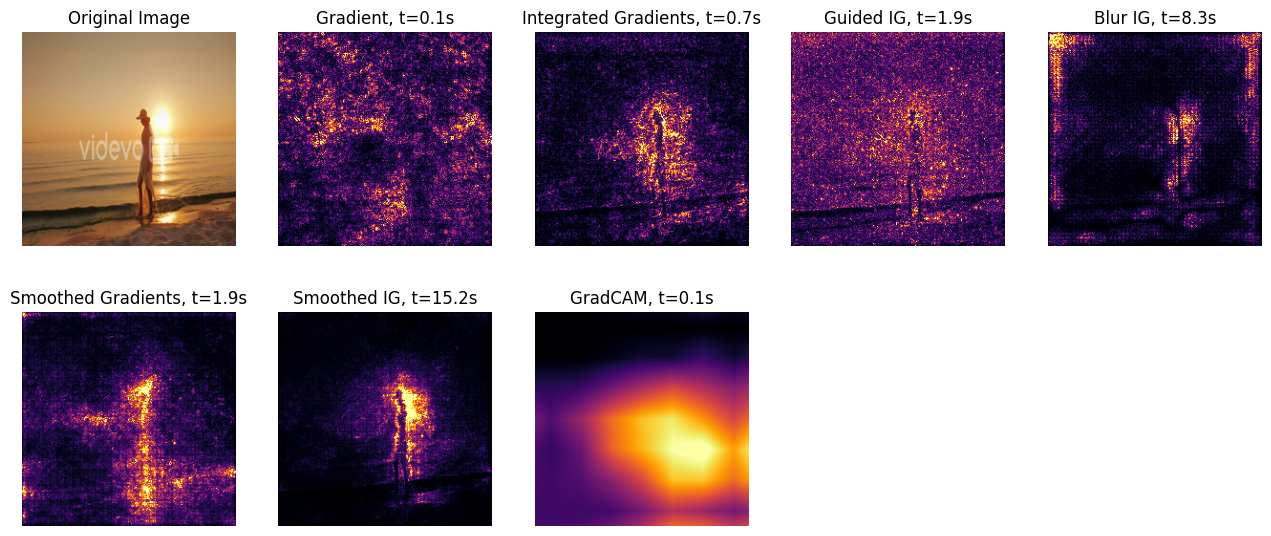

In [87]:
ROWS = 2
COLS = 5
UPSCALE_FACTOR = 8

plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR / 6))

ShowImage(im_orig, title='Original Image', ax=plt.subplot(ROWS, COLS, 1))
images = [gradient_mask_grayscale, 
          integrated_gradients_mask_grayscale, 
          guided_ig_mask_grayscale, 
          blur_ig_mask_grayscale, 
          gradient_smoothedmask_grayscale, 
          integrated_gradients_smoothedmask_grayscale, 
          grad_cam_mask_grayscale, ]
methods_names = ['Gradient', 'Integrated Gradients', 'Guided IG', 'Blur IG', 'Smoothed Gradients', 'Smoothed IG', 'GradCAM']

for i in range(6):
    ShowHeatMap(images[i], title=methods_names[i]+f", t={times[i]:.1f}s", ax=plt.subplot(ROWS, COLS, i+2))
ShowHeatMap(images[-1], title=methods_names[-1]+f", t={times[i+1]:.1f}s", ax=plt.subplot(ROWS, COLS, i+3))


In [ ]:
#for velocity purpose, we only plot 

In [115]:
import os 
img_paths_weap = [os.path.join("test/norm", x) for x in os.listdir("test/norm/")[:10] ]

In [85]:

image_dataset_test = datasets.ImageFolder(root=test_path, transform=data_transform_without_normalization)
normalize_transform_actual = transforms.Normalize(mean=train_mean, std=train_std)

idx_to_class = {v: k for k, v in image_dataset_test.class_to_idx.items()}


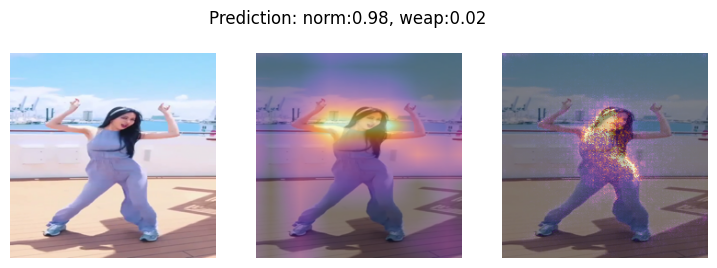

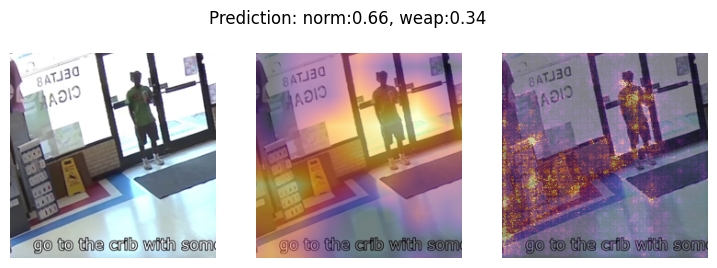

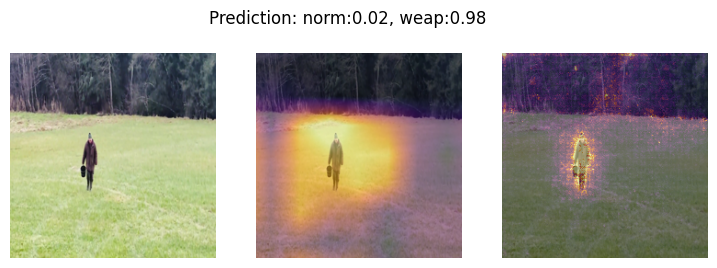

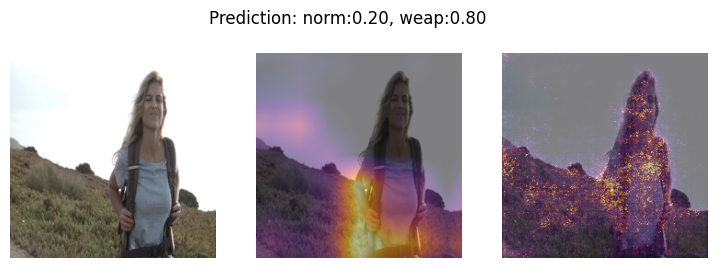

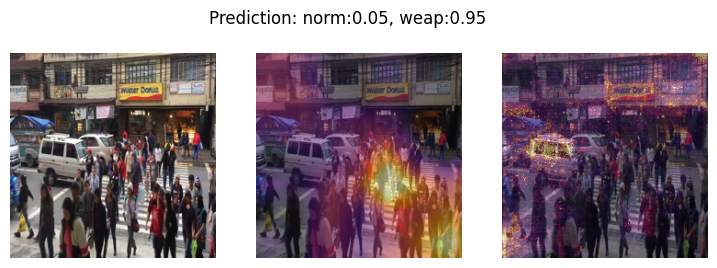

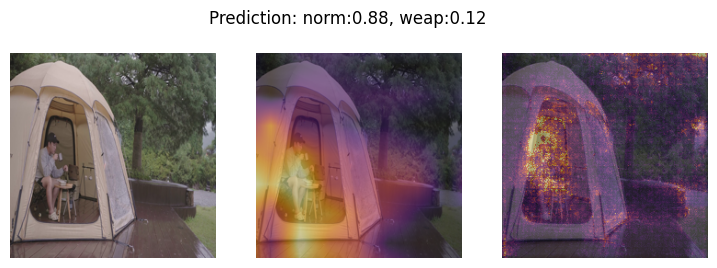

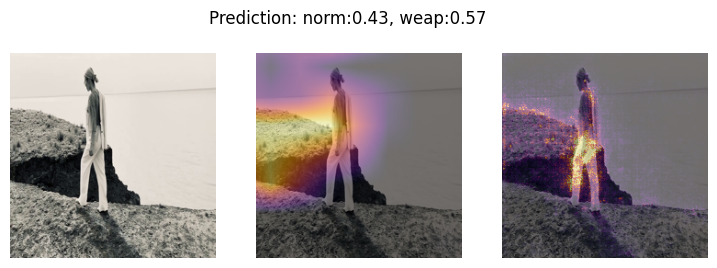

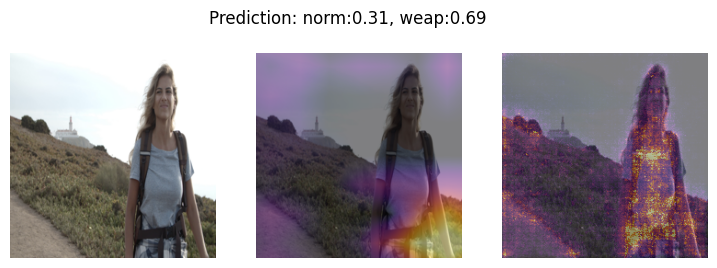

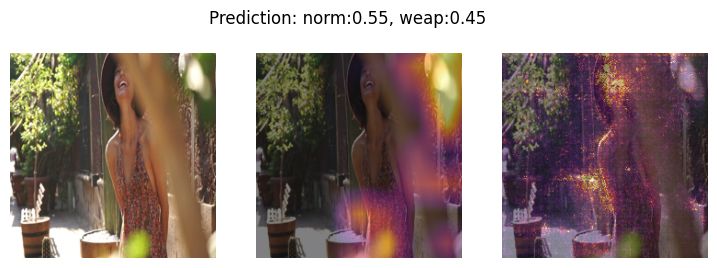

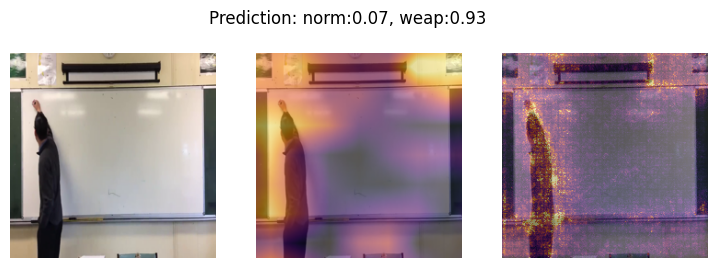

In [116]:
cmap = plt.cm.inferno
def show_saliency_mixed(model, img_paths):
    model.eval()
    gradcams = []
    smoothgrads=[]
    images=[]
    
    for img_path in img_paths:
        
        im_orig = LoadImage(img_path)
        im_tensor = PreprocessImages([im_orig])
        
        predictions = model(im_tensor)
        probs = torch.nn.Softmax(dim=1)(predictions).detach().numpy()

        predictions = predictions.detach().numpy()
        prediction_class = np.argmax(predictions[0])
        call_model_args = {class_idx_str: prediction_class}

        im = im_orig.astype(np.float32)
        
        #gradCam
        grad_cam = saliency.GradCam()
        grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
        grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)

        #smoothgrad
        gradient_saliency = saliency.GradientSaliency()
        gradient_smoothedmask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)
        gradient_smoothedmask_grayscale = saliency.VisualizeImageGrayscale(gradient_smoothedmask_3d)

        gradcam = cmap(grad_cam_mask_grayscale)[:,:,:3]
        smoothgrad = cmap(gradient_smoothedmask_grayscale)[:,:,:3]
        
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        fig.suptitle(f"Prediction: norm:{probs[0,0]:.2f}, weap:{probs[0,1]:.2f}")
        ax[0].imshow(im_orig, )
        ax[0].axis('off')
        ax[1].imshow((0.5*im_orig + 0.5 * 255 * gradcam).astype(np.uint8), )
        ax[1].axis('off')
        ax[2].imshow((0.5*im_orig + 0.5 * 255 * smoothgrad).astype(np.uint8), )
        ax[2].axis('off')
        plt.show()
    
show_saliency_mixed(model, img_paths_weap)
